# ReBLEU Evaluation

aka Better BLEU aka Rewritten BLEU aka Recall included BLEU

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sacrebleu
sacrebleu.__version__ 
assert sacrebleu.__version__ == '1.4.6'

In [8]:
from pathlib import Path
import csv
import collections as coll
import logging as log

log.basicConfig(level=log.INFO)

# Step 1: Read Human annotated scores at system level

In [14]:
!ls ../wmt/metrics-task/wmt19-metrics-task-package/manual-evaluation/

DA2RR		 DA-syslevelhybrids.csv  README
DA-syslevel.csv  hybrid-scoring		 RR-seglevel.csv


In [28]:
wmt19_metrics = Path('../wmt/metrics-task/wmt17-metrics-task-package/')
gold_sys_file = wmt19_metrics / 'manual-evaluation/DA-syslevel.csv'
!shuf {gold_sys_file} | head

en-fi 0.09 online-G.0
en-tr 0.206 uedin-nmt.4932
en-zh 0.208 SogouKnowing-nmt.5131
tr-en 0.294 online-B.0
en-fi -0.298 TALP-UPC.4939
zh-en -0.209 PROMT-SMT.5125
en-de -0.27 C-3MA.4959
en-cs -0.236 tuning-task-ufal_8gb.sgm.0
en-tr -0.554 jhu-nmt-lattice-rescore.4904
en-cs 0.308 uedin-nmt.4956


In [29]:
def read_sys_scores(path):
    with path.open() as f:
        lines = [l.strip().split() for l in f]
    rows = lines[1:] # skip header
    
    mem = coll.defaultdict(dict)
    for lang_pair, score, name in rows:
        assert name not in mem[lang_pair]  # name is unique
        mem[lang_pair][name] = float(score)
    return dict(mem)

gold_sys_scores = read_sys_scores(gold_sys_file)
gold_sys_scores['de-en']

{'online-B.0': 0.213,
 'online-A.0': 0.169,
 'KIT.4951': 0.165,
 'uedin-nmt.4723': 0.162,
 'RWTH-nmt-ensemble.4920': 0.131,
 'SYSTRAN.4846': 0.098,
 'LIUM-NMT.4733': 0.029,
 'TALP-UPC.4830': -0.058,
 'online-G.0': -0.072,
 'C-3MA.4958': -0.103,
 'online-F.0': -0.26}

# Step 2: Locate system outputs and references

In [33]:
wmt19_tests = Path('../wmt19/wmt19-submitted-data/txt/')
!ls {wmt19_tests}

references  sources  system-outputs


In [7]:
ls {wmt19_tests}/system-outputs/newstest2019/de-en/ {wmt19_tests}/references/newstest2019-deen-ref.en

../wmt19/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en

../wmt19/wmt19-submitted-data/txt/system-outputs/newstest2019/de-en/:
newstest2019.dfki-nmt.6478.de-en
newstest2019.Facebook_FAIR.6750.de-en
newstest2019.JHU.6809.de-en
newstest2019.MLLP-UPV.6899.de-en
newstest2019.MSRA.MADL.6910.de-en
newstest2019.NEU.6801.de-en
newstest2019.online-A.0.de-en
newstest2019.online-B.0.de-en
newstest2019.online-G.0.de-en
newstest2019.online-X.0.de-en
newstest2019.online-Y.0.de-en
newstest2019.PROMT_NMT_DE-EN.6683.de-en
newstest2019.RWTH_Aachen_System.6818.de-en
newstest2019.TartuNLP-c.6502.de-en
newstest2019.UCAM.6461.de-en
newstest2019.uedin.6749.de-en


In [34]:
def get_outputs(lang_pair):
    src, tgt = lang_pair.split('-')
    ref = wmt19_tests / f'references/newstest2019-{src}{tgt}-ref.{tgt}'
    log.info(f'reference : {ref}')
    assert ref.exists()
    out_dir = wmt19_tests / f'system-outputs/newstest2019/{src}-{tgt}/'
    sys_outs = list(out_dir.glob(f'*.{src}-{tgt}'))
    log.info(f'Found {len(sys_outs)} systems for {lang_pair}')
    sys_names = ['.'.join(f.name.split('.')[1:-1]) for f in sys_outs]
    assert len(set(sys_names)) == len(sys_names) # unique
    sys_outs = list(zip(sys_names, sys_outs))
    return ref, sys_outs

for langs in gold_sys_scores.keys():
    ref, sys_outs = get_outputs(langs)
    for i, (sys_name, out_path) in enumerate(sys_outs):
        # check human scores ie golden truth exists
        if sys_name not in gold_sys_scores[langs]:
            log.warning(f'{langs} :: gold truth not found for system: {sys_name}')    

INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-encs-ref.cs
INFO:root:Found 11 systems for en-cs
INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-engu-ref.gu
INFO:root:Found 11 systems for en-gu
INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-enlt-ref.lt
INFO:root:Found 12 systems for en-lt
INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-decs-ref.cs
INFO:root:Found 11 systems for de-cs
INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-enkk-ref.kk
INFO:root:Found 11 systems for en-kk
INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-fien-ref.en
INFO:root:Found 12 systems for fi-en
INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-zhen-ref.en
INFO:root:Found 15 systems for zh-en
INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-enzh-ref.zh
INFO:

In [35]:
from sacrebleu import corpus_bleu
from sacrebleu.rebleu import corpus_rebleu

def read_lines(path):
    with path.open(encoding='utf8', errors='ignore') as f:
        return [line.strip() for line in f]

In [36]:
gold_sys_scores.keys()

dict_keys(['en-cs', 'en-gu', 'en-lt', 'de-cs', 'en-kk', 'fi-en', 'zh-en', 'en-zh', 'fr-de', 'ru-en', 'kk-en', 'gu-en', 'lt-en', 'en-de', 'en-ru', 'en-fi', 'de-en', 'de-fr'])

In [46]:
import multiprocessing as mp
import os
cpu_count = mp.cpu_count()
if 'SLURM_CPUS_ON_NODE' in os.environ:
    cpu_count = int(os.environ['SLURM_CPUS_ON_NODE'])
print('cpus', cpu_count)

selected_langs = ['de-en', 'en-de', 'en-ru', 'ru-en']
selected_langs = gold_sys_scores.keys()

def read_args():
    #for langs in gold_sys_scores.keys():
    for langs in selected_langs:
        ref, sys_outs = get_outputs(langs)
        ref_lines = [read_lines(ref)]
        for (sys_name, sys_path) in sys_outs:
            if sys_name not in gold_sys_scores[langs]:
                log.warning(f'{sys_name} doesnt have gold truth; skipped')
                continue
            yield langs, sys_name, sys_path, ref_lines

def bleu_scores(args):
    langs, sys_name, sys_path, ref_lines = args
    sys_lines = read_lines(sys_path)
    tokenize = '13a'
    if '-zh' in langs:
        tokenize = 'zh'
    elif '-gu' in langs:
        tokenize = 'intl'
    bleu = corpus_bleu(sys_lines, ref_lines, force=True, tokenize=tokenize)
    rebleu_micro = corpus_rebleu(sys_lines, ref_lines, force=True, average='micro', tokenize=tokenize)
    rebleu_macro = corpus_rebleu(sys_lines, ref_lines, force=True, average='macro', tokenize=tokenize)
    gold_score = gold_sys_scores[langs][sys_name]
    print(f'{langs}\t{sys_name}\t{bleu.score:.2f}\t{gold_score:.4f}\t{rebleu_micro.score:.4f}\t{rebleu_macro.score:.4f}')
    return langs, sys_name, {
        'sacre_bleu': bleu.score,
        'gold': gold_score,
        'rebleu_micro': rebleu_micro.score,
        'rebleu_macro': rebleu_macro.score
    }

sys_scores = coll.defaultdict(lambda: coll.defaultdict(dict))

with mp.Pool(cpu_count) as pool:
    for res in pool.imap(bleu_scores, read_args()):
        langs, sys_name, scores = res
        sys_scores[langs][sys_name].update(scores)
print("Done")

cpus 36


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-encs-ref.cs
INFO:root:Found 11 systems for en-cs
INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-engu-ref.gu
INFO:root:Found 11 systems for en-gu
INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-enlt-ref.lt
INFO:root:Found 12 systems for en-lt
INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-decs-ref.cs
INFO:root:Found 11 systems for de-cs


en-lt	tilde-nc-nmt.6696	18.99	0.3880	0.3461	0.1870
en-lt	MSRA.MASS.6954	20.08	0.3870	0.3429	0.1855
en-lt	eTranslation.6836	16.54	0.0360	0.3199	0.1642
en-lt	online-X.0	9.62	-0.6660	0.2396	0.1020
en-lt	NEU.6760	16.95	-0.0540	0.3144	0.1614
en-lt	GTCOM-Primary.7001	18.11	0.1550	0.3296	0.1766
en-lt	tilde-c-nmt.6695	18.59	0.2620	0.3385	0.1812
en-lt	TartuNLP-c.6510	12.33	-0.3830	0.2670	0.1147
en-lt	MSRA.MASS.6931	19.08	0.2590	0.3370	0.1781
en-lt	online-B.0	14.98	-0.0610	0.2936	0.1419


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-enkk-ref.kk
INFO:root:Found 11 systems for en-kk


en-lt	online-A.0	9.05	-0.6200	0.2508	0.1048
en-lt	online-G.0	8.42	-0.8050	0.2383	0.0982
en-gu	online-B.0	61.76	0.6630	0.6560	0.5452
en-gu	online-X.0	10.93	-0.5020	0.2744	0.1025
en-gu	CUNI-T2T-transfer-engu.6466	14.35	0.2540	0.3579	0.1658
en-gu	Ju_Saarland_clean_num_135_bpe.6617	21.99	-0.0790	0.3609	0.1622
en-gu	MSRA.CrossBERT.6991	16.57	0.3180	0.3338	0.1429
en-gu	online-G.0	9.06	-0.4900	0.2903	0.1320
en-gu	UdS-DFKI.6866	7.04	-0.7180	0.2488	0.0894
en-gu	UEDIN.6849	16.27	0.3050	0.3370	0.1540
en-gu	NICT.6604	10.33	-0.4650	0.2833	0.1008
en-gu	GTCOM-Primary.6970	28.69	0.5970	0.4211	0.2440


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-fien-ref.en
INFO:root:Found 12 systems for fi-en


en-gu	IITP-MT.6827	8.25	-0.4580	0.2653	0.0880
de-cs	Unsupervised.de-cs.6935	16.06	-0.4050	0.3239	0.1415
en-cs	CUNI-Transformer-T2T-2019.6851	29.39	0.3880	0.4433	0.2656
en-cs	CUNI-Transformer-T2T-2018.6457	29.86	0.4010	0.4473	0.2696
en-cs	CUNI-DocTransformer-T2T.6751	29.94	0.4020	0.4480	0.2724
en-cs	online-B.0	21.76	-0.3360	0.3891	0.2080
en-kk	online-G.0	13.19	0.0780	0.2811	0.1467
en-kk	rug_enkk_bpe.6804	10.30	-0.0490	0.2600	0.1271
en-kk	NICT.6550	6.43	-0.4930	0.2134	0.0844
en-cs	online-G.0	20.08	-0.3000	0.3749	0.1952
en-cs	online-Y.0	23.53	-0.1560	0.4014	0.2210
en-cs	CUNI-DocTransformer-Marian.6922	28.14	0.2230	0.4308	0.2532
de-cs	CAiRE.6949	10.24	-0.8070	0.2772	0.0978


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-zhen-ref.en
INFO:root:Found 15 systems for zh-en


en-cs	uedin.6667	27.89	0.2060	0.4383	0.2605
en-cs	TartuNLP-c.6633	22.82	-0.1950	0.3955	0.2153
en-cs	online-A.0	18.11	-0.5940	0.3557	0.1743
en-cs	online-X.0	15.01	-0.6510	0.3273	0.1476
en-kk	online-B.0	16.89	0.2430	0.3116	0.1713
en-kk	NEU.6755	11.11	0.1260	0.2655	0.1287
en-kk	CUNI-T2T-transfer-enkk.6554	8.70	0.0970	0.2466	0.1145
en-kk	MSRA.CrossBERT.6874	10.62	0.1080	0.2563	0.1160
en-kk	talp_upc_2019_enkk.6355	6.45	-0.3280	0.2217	0.0919
en-kk	UAlacant_-_NMT.6718	9.97	0.2620	0.2615	0.1284
en-kk	UAlacant_-_NMT+RBMT.6722	9.90	0.2220	0.2593	0.1275
en-kk	DBMS-KU_ENKK.6730	0.95	-1.3950	0.1173	0.0296


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-enzh-ref.zh
INFO:root:Found 12 systems for en-zh


de-cs	Unsupervised.de-cs.6929	17.75	-0.3280	0.3363	0.1513
de-cs	NICT.6938	20.05	0.3670	0.3688	0.1879
de-cs	online-G.0	17.87	0.3190	0.3601	0.1794
de-cs	online-A.0	16.44	0.1340	0.3436	0.1635
de-cs	CUNI-Unsupervised-NER-post.6934	14.07	-0.1650	0.3357	0.1529
de-cs	online-Y.0	21.02	0.4260	0.3808	0.2013
de-cs	online-B.0	19.54	0.3860	0.3725	0.1921
de-cs	NEU_KingSoft.6766	18.86	0.1790	0.3554	0.1722
de-cs	lmu-unsup-nmt-de-cs.6845	17.03	-0.0990	0.3387	0.1533
fi-en	online-Y.0	29.86	0.2650	0.5020	0.3126
fi-en	apertium-fin-eng-unconstrained-fien.6449	7.56	-0.5160	0.3611	0.1711
fi-en	parfda.6526	19.20	-0.2090	0.4508	0.2387


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-frde-ref.de
INFO:root:Found 10 systems for fr-de


fi-en	USYD.6995	33.03	0.2450	0.5159	0.3213
fi-en	TartuNLP-c.6905	23.91	-0.0530	0.4620	0.2461
fi-en	online-X.0	22.19	-0.0710	0.4428	0.2247
fi-en	online-A.0	23.85	0.0120	0.4650	0.2643
fi-en	Helsinki_NLP.6889	26.67	0.1050	0.4781	0.2812
fi-en	online-B.0	26.97	0.1070	0.4872	0.2885
fi-en	GTCOM-Primary.6946	31.45	0.2610	0.5138	0.3343
fi-en	online-G.0	21.00	-0.0440	0.4538	0.2574
fi-en	MSRA.NAO.6983	31.89	0.2850	0.5170	0.3359
zh-en	Apprentice-c.6706	16.94	-0.9570	0.4759	0.2198


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-ruen-ref.en
INFO:root:Found 14 systems for ru-en


zh-en	Baidu-system.6940	37.97	0.2950	0.5562	0.3617
zh-en	MSRA.MASS.6942	38.29	0.1950	0.5705	0.3735
zh-en	online-X.0	21.44	-0.4830	0.4693	0.2252
fr-de	online-A.0	26.75	-0.0390	0.4415	0.2345
zh-en	KSAI-system.6927	37.46	0.2660	0.5509	0.3527
zh-en	online-Y.0	28.71	0.0490	0.5276	0.2985
fr-de	eTranslation.6262	32.71	0.2460	0.4856	0.2793
fr-de	online-Y.0	25.44	0.0010	0.4273	0.2215
fr-de	MLLP-UPV.6654	27.47	0.0370	0.4433	0.2394
fr-de	LIUM.6720	29.69	0.0820	0.4605	0.2587
fr-de	MSRA.MADL.6893	35.04	0.2670	0.4973	0.2983
fr-de	online-G.0	24.22	-0.0180	0.4229	0.2114
zh-en	NICT.6814	30.99	0.0010	0.5062	0.2833
fr-de	online-X.0	22.62	-0.4100	0.4058	0.1983
fr-de	TartuNLP-c.6514	24.81	-0.0980	0.4260	0.2123


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-kken-ref.en
INFO:root:Found 11 systems for kk-en


zh-en	NEU.6832	34.19	0.1930	0.5449	0.3402
zh-en	MSRA.MASS.6996	39.33	0.2030	0.5726	0.3775
zh-en	online-B.0	42.21	0.1610	0.5850	0.3746
zh-en	online-G.0	25.24	-0.2020	0.5104	0.2759
zh-en	online-A.0	28.84	-0.0650	0.5258	0.3096
en-zh	online-B.0	36.91	-0.1250	0.5840	0.4651
en-zh	online-X.0	24.26	-0.5530	0.4937	0.2822
zh-en	BTRANS-ensemble.6992	33.84	0.1030	0.5422	0.3375
zh-en	UEDIN.6530	27.65	0.0540	0.5152	0.2933
en-zh	UEDIN.6158	34.38	0.0170	0.5699	0.3868
en-zh	online-G.0	30.17	-0.2620	0.5580	0.4179
en-zh	NICT.6817	34.47	0.0000	0.5472	0.3141


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-guen-ref.en
INFO:root:Found 12 systems for gu-en


zh-en	BTRANS.6825	33.44	0.1860	0.5399	0.3350
en-zh	BTRANS.6821	38.30	0.0090	0.5753	0.4372
en-zh	online-Y.0	32.38	-0.2180	0.5609	0.3726
en-zh	online-A.0	31.24	0.0520	0.5248	0.3387
en-zh	NEU.6830	39.88	0.2090	0.5872	0.4252
en-zh	KSAI-system.6982	42.41	0.3060	0.5961	0.4620
kk-en	UMD.6736	9.20	-0.4770	0.3499	0.1225
en-zh	Baidu-system.6932	42.37	0.2800	0.6040	0.5011
kk-en	online-B.0	31.99	0.2700	0.4990	0.3116
en-zh	xzl-nmt.6847	35.60	0.0420	0.5781	0.4104


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-lten-ref.en
INFO:root:Found 11 systems for lt-en


kk-en	NEU.6753	30.48	0.2180	0.4841	0.3060
kk-en	CUNI-T2T-transfer-kken.6436	18.48	0.0030	0.4285	0.2221
fr-de	online-B.0	26.40	-0.0340	0.4388	0.2296
kk-en	rug_kken_morfessor.6677	27.94	0.1890	0.4660	0.2876
kk-en	NRC-CNRC.6895	24.94	0.0920	0.4443	0.2576
kk-en	NICT.6770	26.21	0.0640	0.4494	0.2606
gu-en	NICT.6603	17.22	0.0440	0.3956	0.1956
gu-en	UEDIN.6534	21.45	0.1260	0.4129	0.2195
gu-en	GTCOM-Primary.6969	17.48	0.1000	0.4047	0.2042
gu-en	Ju_Saarland.6525	11.85	-0.5980	0.3599	0.1324


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-ende-ref.de
INFO:root:Found 22 systems for en-de


kk-en	online-G.0	25.72	0.1330	0.4481	0.2592
gu-en	CUNI-T2T-transfer-guen.6431	17.45	0.0900	0.3992	0.1957
kk-en	talp_upc_2019_kken.6657	24.92	0.1130	0.4512	0.2626
kk-en	DBMS-KU_KKEN.6726	3.40	-1.0580	0.2276	0.0441
kk-en	Frank_s_MT.6127	19.78	0.0660	0.4262	0.2564
gu-en	aylien_mt_gu-en_multilingual.6826	16.79	0.0660	0.4082	0.2072
gu-en	IITP-MT.6824	9.38	-0.1920	0.3419	0.1357
ru-en	online-G.0	38.51	0.1340	0.5387	0.3562
ru-en	afrl-syscomb19.6782	37.20	0.0120	0.5367	0.3440
ru-en	online-B.0	45.28	0.1210	0.5818	0.4084
ru-en	NICT.6561	28.21	-0.3030	0.4680	0.2308
ru-en	afrl-ewc.6659	34.31	-0.0390	0.5136	0.3084
ru-en	online-X.0	30.42	-0.0970	0.4854	0.2604
ru-en	Facebook_FAIR.6937	39.99	0.1560	0.5556	0.3774
gu-en	NEU.6756	24.90	0.2100	0.4425	0.2505
ru-en	TartuNLP-u.6650	30.76	-0.0400	0.4962	0.2810
ru-en	online-A.0	35.57	0.0290	0.5240	0.3215
ru-en	NEU.6803	40.00	0.1150	0.5560	0.3791
gu-en	online-G.0	8.85	-0.1890	0.3651	0.1802
ru-en	eTranslation.6598	37.43	0.1220	0.5389	0.3450
ru-en	MSRA.SCA.6976	40

INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-enru-ref.ru
INFO:root:Found 12 systems for en-ru


gu-en	UdS-DFKI.6861	9.55	-0.2770	0.3391	0.1433
ru-en	rerank-re.6540	37.53	0.0840	0.5400	0.3517
lt-en	online-A.0	24.35	-0.0560	0.4677	0.2689
lt-en	online-B.0	29.46	0.1070	0.5147	0.3326
lt-en	TartuNLP-c.6908	24.14	-0.0590	0.4702	0.2637
lt-en	GTCOM-Primary.6998	36.29	0.2340	0.5438	0.3687
lt-en	MSRA.MASS.6945	35.48	0.2060	0.5316	0.3601
lt-en	online-X.0	17.57	-0.3960	0.4254	0.2032
lt-en	tilde-c-nmt.6876	30.26	0.2020	0.5195	0.3329
lt-en	JUMT.6616	16.57	-0.3370	0.4243	0.1921
lt-en	online-G.0	19.49	-0.2840	0.4445	0.2453


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-enfi-ref.fi
INFO:root:Found 12 systems for en-fi


lt-en	tilde-nc-nmt.6881	31.55	0.2160	0.5316	0.3492
lt-en	NEU.6759	34.25	0.2130	0.5259	0.3535
en-de	Microsoft-WMT19-sentence-level.6785	42.97	0.0940	0.5518	0.3642
en-de	PROMT_NMT_EN-DE.6674	37.94	0.0010	0.5107	0.3089
en-de	JHU.6819	42.52	0.0810	0.5417	0.3472
en-de	online-Y.0	42.02	0.0380	0.5465	0.3582
en-de	online-X.0	29.48	-0.4000	0.4515	0.2361
en-de	Helsinki-NLP.6820	41.41	0.0770	0.5393	0.3497
en-de	TartuNLP-c.6508	36.43	-0.1320	0.5005	0.2971
en-de	MLLP-UPV.6651	41.72	0.1890	0.5373	0.3504
en-de	online-G.0	35.14	-0.1190	0.4986	0.2969
en-de	lmu-ctx-tf-single-en-de.6981	40.31	0.0100	0.5329	0.3408


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en
INFO:root:Found 16 systems for de-en


en-de	online-A.0	41.03	-0.0720	0.5301	0.3377
en-de	UdS-DFKI.6871	38.65	-0.1290	0.5208	0.3263
en-de	UCAM.6731	43.01	0.2130	0.5486	0.3619
en-de	MSRA.MADL.6926	44.93	0.2140	0.5586	0.3771
en-de	online-B.0	41.24	0.0940	0.5415	0.3581
en-de	Microsoft-WMT19-document-level.6808	43.85	0.2960	0.5549	0.3689
en-de	Microsoft-WMT19-sentence_document.6974	43.92	0.3110	0.5554	0.3698
en-de	Facebook_FAIR.6862	42.67	0.3470	0.5469	0.3617
en-de	en_de_task.6790	16.85	-1.7690	0.3797	0.1440
en-de	dfki-nmt.6479	41.57	0.1190	0.5334	0.3381
en-de	NEU.6763	43.52	0.2080	0.5502	0.3665
en-de	eTranslation.6823	41.90	0.1300	0.5432	0.3485
en-ru	NEU.6773	33.98	0.2230	0.4577	0.2640
en-ru	rerank-er.6572	27.75	-0.1880	0.4195	0.2104
en-ru	TartuNLP-u.6645	24.84	-0.3100	0.3894	0.1843
en-ru	PROMT_NMT_EN-RU.6989	30.67	0.2190	0.4398	0.2412


INFO:root:reference : ../wmt19/wmt19-submitted-data/txt/references/newstest2019-defr-ref.fr
INFO:root:Found 11 systems for de-fr


en-fi	MSRA.NAO.6985	27.43	0.5700	0.3979	0.2243
en-ru	Facebook_FAIR.6724	36.34	0.5060	0.4782	0.2889
en-ru	online-B.0	30.53	0.2690	0.4509	0.2499
en-ru	online-X.0	23.12	-0.3630	0.3774	0.1803
en-ru	online-G.0	32.70	0.2790	0.4591	0.2612
en-fi	online-B.0	20.48	0.0370	0.3378	0.1649
en-ru	NICT.6563	13.91	-1.2700	0.3303	0.1118
en-ru	online-Y.0	28.93	0.1560	0.4309	0.2320
en-ru	USTC-MCC.6795	34.67	0.3320	0.4656	0.2754
en-ru	online-A.0	22.77	-0.2680	0.3914	0.1882
en-fi	TartuNLP-c.6509	18.48	-0.1250	0.3231	0.1500
de-en	online-B.0	45.20	0.1210	0.5958	0.4488
de-en	NEU.6801	40.51	0.0390	0.5606	0.3978
de-en	MSRA.MADL.6910	42.79	0.1360	0.5749	0.4187
en-fi	NICT.6359	23.23	0.1990	0.3625	0.1875
en-fi	online-X.0	12.34	-0.3980	0.2505	0.0949
de-en	online-A.0	36.41	0.0500	0.5398	0.3593
de-en	Facebook_FAIR.6750	40.75	0.1460	0.5648	0.4088
de-en	uedin.6749	34.97	0.0110	0.5347	0.3462
de-en	online-X.0	28.57	-0.1920	0.4746	0.2586
de-en	MLLP-UPV.6899	39.31	0.0670	0.5526	0.3874
de-en	TartuNLP-c.6502	33.92	0.0060	0.526

In [41]:
from scipy import stats
import numpy as np
a = np.array([0, 0, 0, 1, 1, 1, 1])
b = np.arange(7)
stats.pearsonr(a, b)

(0.8660254037844386, 0.011724811003954649)

In [44]:
metric_names = ['gold', 'sacre_bleu', 'rebleu_micro', 'rebleu_macro']

In [39]:
sys_scores.keys()

dict_keys(['en-cs', 'en-gu', 'en-lt', 'de-cs', 'en-kk', 'fi-en', 'zh-en', 'en-zh', 'fr-de', 'ru-en', 'kk-en', 'gu-en', 'lt-en', 'en-de', 'en-ru', 'en-fi', 'de-en', 'de-fr'])

In [47]:
names = "\t".join(metric_names[1:])
print(f'Lang \t {names} \t DeltaMicro\t DeltaMacro')

for langs in selected_langs:
    arr = [[d[m] for m in metric_names] for d in sys_scores[langs].values()]
    arr = np.array(arr)
    line = []
    for i in range(1, len(metric_names)):
        rho, p_val = stats.spearmanr(arr[:, 0], arr[:, i])
        line.append(rho)
    line.append(line[1] - line[0])
    line.append(line[2] - line[0])
    line = [langs] + [f'{x:.3f}' for x in line]
    print('\t'.join(line))


Lang 	 sacre_bleu	rebleu_micro	rebleu_macro 	 DeltaMicro	 DeltaMacro
en-cs	0.991	0.982	0.982	-0.009	-0.009
en-gu	0.864	0.845	0.800	-0.018	-0.064
en-lt	0.951	1.000	1.000	0.049	0.049
de-cs	0.900	0.991	1.000	0.091	0.100
en-kk	0.627	0.718	0.764	0.091	0.136
fi-en	0.916	0.958	0.972	0.042	0.056
zh-en	0.857	0.861	0.879	0.004	0.021
en-zh	0.762	0.685	0.490	-0.077	-0.273
fr-de	0.855	0.855	0.855	0.000	0.000
ru-en	0.846	0.829	0.846	-0.018	0.000
kk-en	0.900	0.909	0.927	0.009	0.027
gu-en	0.864	0.918	0.955	0.055	0.091
lt-en	0.955	0.955	0.955	0.000	0.000
en-de	0.904	0.883	0.887	-0.021	-0.017
en-ru	0.944	0.993	0.979	0.049	0.035
en-fi	0.923	0.972	0.972	0.049	0.049
de-en	0.825	0.825	0.870	0.000	0.046
de-fr	0.945	0.945	0.982	0.000	0.036


In [42]:
names = "\t".join(metric_names[1:])
print(f'Lang \t {names} \t DeltaMicro\t DeltaMacro')

for langs in selected_langs:
    arr = [[d[m] for m in metric_names] for d in sys_scores[langs].values()]
    arr = np.array(arr)
    line = []
    for i in range(1, len(metric_names)):
        rho, p_val = stats.spearmanr(arr[:, 0], arr[:, i])
        line.append(rho)
    line.append(line[1] - line[0])
    line.append(line[2] - line[0])
    line = [langs] + [f'{x:.3f}' for x in line]
    print('\t'.join(line))


Lang 	 sacre_bleu	rebleu_micro	rebleu_macro 	 DeltaMicro	 DeltaMacro
en-cs	0.991	0.982	0.982	-0.009	-0.009
en-gu	0.864	0.845	0.800	-0.018	-0.064
en-lt	0.951	1.000	1.000	0.049	0.049
de-cs	0.900	0.991	1.000	0.091	0.100
en-kk	0.627	0.764	0.791	0.136	0.164
fi-en	0.916	0.958	0.972	0.042	0.056
zh-en	0.857	0.861	0.879	0.004	0.021
en-zh	0.755	0.762	0.497	0.007	-0.259
fr-de	0.855	0.855	0.855	0.000	0.000
ru-en	0.846	0.824	0.846	-0.022	0.000
kk-en	0.900	0.927	0.891	0.027	-0.009
gu-en	0.864	0.909	0.936	0.045	0.073
lt-en	0.955	0.955	0.955	0.000	0.000
en-de	0.904	0.883	0.887	-0.021	-0.017
en-ru	0.944	0.979	0.979	0.035	0.035
en-fi	0.923	0.979	0.972	0.056	0.049
de-en	0.825	0.850	0.870	0.025	0.046
de-fr	0.945	0.936	0.982	-0.009	0.036


---

# REBLEU

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import sacrebleu
from sacrebleu import corpus_bleu, TOKENIZERS, corpus_rebleu

from pathlib import Path
import csv
import collections as coll
import logging as log

log.basicConfig(level=log.INFO)

sacrebleu.__version__ 
assert sacrebleu.__version__ == '1.4.6'

In [7]:
from typing import List, Set
import re

def replace_one_word(word:str, lines: List[str], repl=''):
    assert isinstance(lines, list)
    assert isinstance(word, str)
    res = []
    space_patt = re.compile(r' +')
    for line in lines:
        if word in line:
            line = ' '.join(repl if tok == word else tok for tok in line.split())
            line = space_patt.sub(' ', line).strip()
        res.append(line)
    return res

replace_one_word('the', ['the cat sat on the lazy mat'], repl='')

['cat sat on lazy mat']

In [8]:

def read_lines(path):
    with path.open(encoding='utf8', errors='ignore') as f:
        return [line.strip() for line in f]
    
deen_ref = Path('../wmt19/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en')
tokenizer = TOKENIZERS['13a']

lines = [tokenizer(line.lower()) for line in read_lines(deen_ref)]
log.info(f'{len(lines)} lines in {deen_ref}')
sys = lines
refs = [lines]

INFO:root:2000 lines in ../wmt19/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en


In [9]:
import collections as coll
def term_frequencies(lines):
    toks = (t for l in lines for t in l.split())
    stats = coll.Counter(toks)
    stats = sorted(stats.items(), reverse=True, key=lambda x: x[1])
    return stats

tfreqs = term_frequencies(lines)
tfreqs[:5], tfreqs[-5:], '\n', len(tfreqs)

([('the', 3012), ('.', 1902), (',', 1592), ('of', 849), ('in', 827)],
 [('extra-time', 1),
  ('christopher', 1),
  ('nkunku', 1),
  ('groundbreaking', 1),
  ('belgrade', 1)],
 '\n',
 6933)

In [10]:
corpus_rebleu(sys, refs, force=True).score

1.0

In [60]:
import multiprocessing as mp
import os
cpu_count = mp.cpu_count()
if 'SLURM_CPUS_ON_NODE' in os.environ:
    cpu_count = int(os.environ['SLURM_CPUS_ON_NODE'])
print('cpus', cpu_count)

def compute_bleu(args):
    word, freq = args
    sys = replace_one_word(word, lines, repl='ugwehjsdfelasyigdfu')
    bleu = corpus_bleu(sys, refs, force=True)
    macro_rebleu = corpus_rebleu(sys, refs, force=True, average='macro', smooth_value=0,  max_order=4)
    micro_rebleu = corpus_rebleu(sys, refs, force=True, average='micro', smooth_value=0, max_order=4)
    return [word, freq, bleu.score, macro_rebleu.score, micro_rebleu.score]

points = []
with mp.Pool(cpu_count) as pool:

    data = tfreqs[-50:]
    n = len(data)    
    for stat in pool.imap(compute_bleu, data):
        points.append(stat)
        if len(points) % max(int(n / 10), 5) == 0:
            print(f"{100 * len(points) / len(data):.2f}%...", end=' ')

cpus 36
10.00%... 20.00%... 30.00%... 40.00%... 50.00%... 60.00%... 70.00%... 80.00%... 90.00%... 100.00%... 

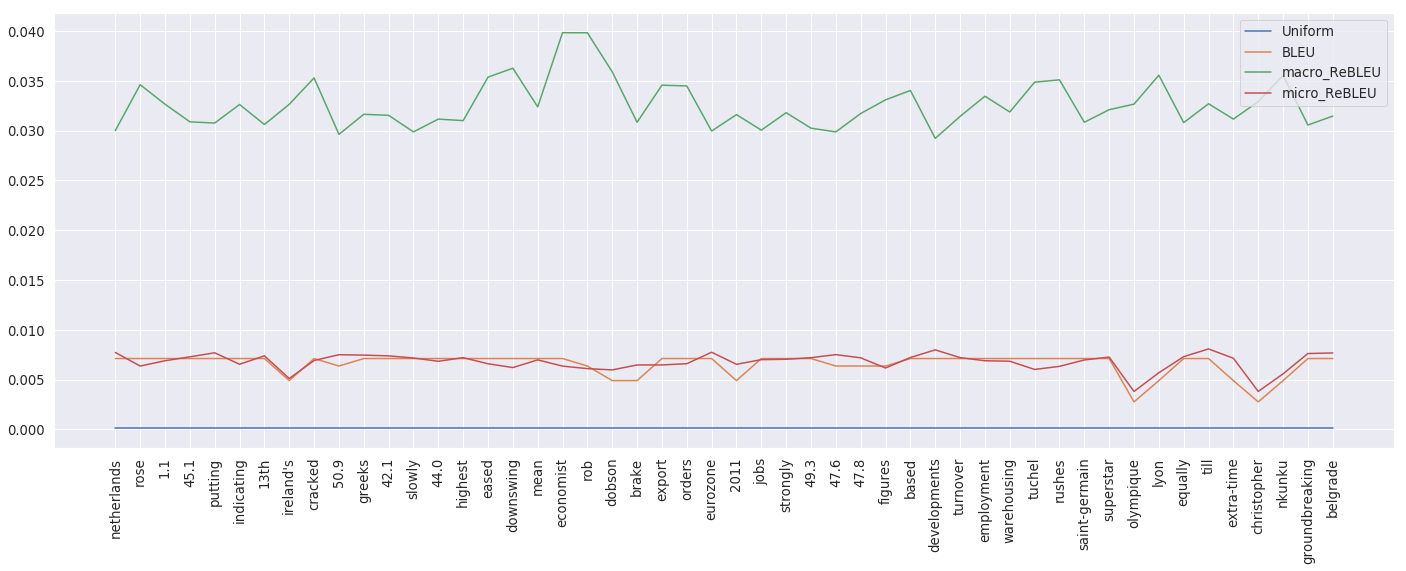

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(x, ys, yscale='log', save=None):
    
    fig = plt.figure(figsize=(24, 8), )
    fig.tight_layout()
    for name, y in ys:
        plt.plot(x, y, label=name)

    plt.xticks(rotation=90) 
    plt.yscale(yscale)
    plt.legend(loc='upper right')
    if save:
        log.info(f'Saving to {save}')
        plt.savefig(save)
    plt.show()
    

pts = points
x = [pt[0] for pt in pts]
uniform = [1/len(tfreqs)] * len(pts)
freqs = [pt[1] for pt in pts]
bleu = [100 - pt[2] for pt in pts]
macro_rebleu = [100 *(1 - pt[3]) for pt in pts]
micro_rebleu = [100 *(1 - pt[4]) for pt in pts]


sns.set(font_scale=1.2)
ys = [
    
      ('Uniform', uniform),
      ('BLEU', bleu),
      ('macro_ReBLEU', macro_rebleu),
      ('micro_ReBLEU', micro_rebleu)
     ]
# save='bleu-vs-rebleu-viz'
plot_histogram(x, ys, yscale='linear')

'/nas/material02/users/tg/projects/beter-bleu/sacre-BLEU/sacrebleu/__init__.py'